In [1]:
# 📘 Notebook: SimCLR Visualizations (UMAP / t-SNE)

# 📌 Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm



2025-03-24 22:54:25.281626: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 22:54:25.346877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742837065.388563   33408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742837065.402553   33408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 22:54:25.475237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 📌 Cell 2: Load Encoder
encoder_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/SimCLR_Pretrained/best_simCLR_Encoder.keras"
encoder = tf.keras.models.load_model(encoder_path, compile=False)



I0000 00:00:1742837075.082613   33408 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# 📌 Cell 3: Load Dataset (Labeled for Visualization)
# Load train or test dataset for visualization
# Use the same parse function from baseline notebook

feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "crop": tf.io.FixedLenFeature([], tf.int64),
    "disease": tf.io.FixedLenFeature([], tf.int64)
}

NUM_CROPS = 9
NUM_DISEASES = 33
BATCH_SIZE = 64

split_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split"
test_tfrecord = os.path.join(split_path, "test.tfrecord")

def parse_tfrecord(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed["image"], channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    crop = parsed["crop"]
    disease = parsed["disease"]
    return image, crop, disease

def load_dataset(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord).batch(BATCH_SIZE)
    return dataset

dataset = load_dataset(test_tfrecord)



In [4]:
# 📌 Cell 4: Extract Features
features, crop_labels, disease_labels = [], [], []
for images, crops, diseases in tqdm(dataset):
    embeddings = encoder(images, training=False)
    features.append(embeddings.numpy())
    crop_labels.extend(crops.numpy())
    disease_labels.extend(diseases.numpy())

features = np.concatenate(features, axis=0)
crop_labels = np.array(crop_labels)
disease_labels = np.array(disease_labels)



2025-03-24 22:54:43.912174: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1742837084.704691   33408 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 22:55:03.238784: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
71it [00:19,  3.66it/s]


/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


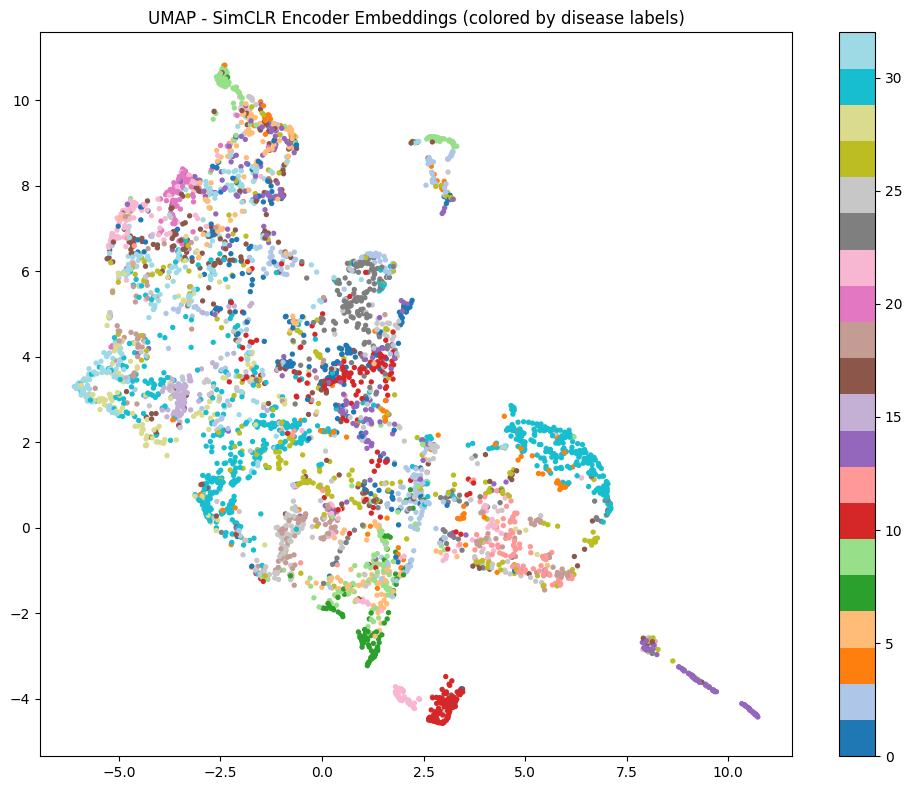

In [5]:
# 📌 Cell 5: UMAP Visualization
reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1)
umap_proj = reducer_umap.fit_transform(features)
plt.figure(figsize=(10, 8))
plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=disease_labels, cmap='tab20', s=8)
plt.title("UMAP - SimCLR Encoder Embeddings (colored by disease labels)")
plt.colorbar()
plt.tight_layout()
os.makedirs("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/simCLR/Encoder/Plots", exist_ok=True)
plt.savefig("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/simCLR/Encoder/Plots/umap_disease_embeddings.png")
plt.show()



/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


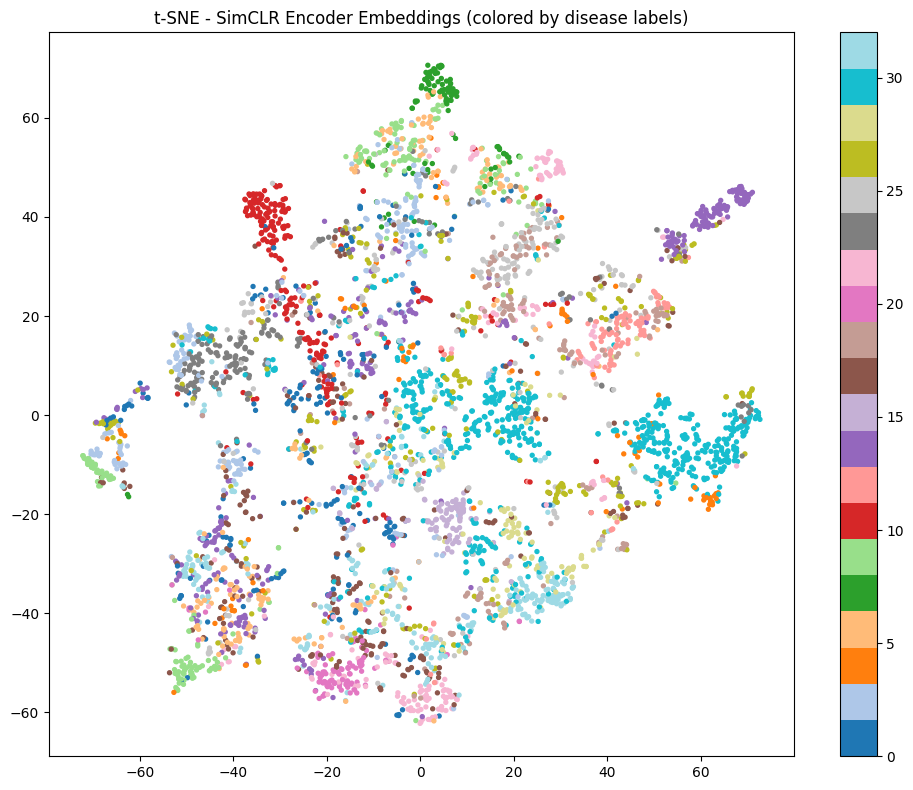

In [6]:
# 📌 Cell 6: t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_proj = tsne.fit_transform(features)
plt.figure(figsize=(10, 8))
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=disease_labels, cmap='tab20', s=8)
plt.title("t-SNE - SimCLR Encoder Embeddings (colored by disease labels)")
plt.colorbar()
plt.tight_layout()
plt.savefig("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/simCLR/Encoder/Plots/tsne_disease_embeddings.png")
plt.show()



In [7]:
# 📌 Cell 7: Save Label Mapping
crop_map = {0: 'Grape', 1: 'Apple', 2: 'Bell_Pepper', 3: 'Corn', 4: 'Strawberry', 5: 'Tomato', 6: 'Cherry', 7: 'Peach', 8: 'Potato'}
disease_map = {i: f"Disease_{i}" for i in range(NUM_DISEASES)}

with open("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/simCLR/Encoder/Plots/label_mappings.txt", "w") as f:
    f.write("Crop Labels:\n")
    for k, v in crop_map.items():
        f.write(f"{k}: {v}\n")
    f.write("\nDisease Labels:\n")
    for k, v in disease_map.items():
        f.write(f"{k}: {v}\n")

print("✅ UMAP/t-SNE plots and label mappings saved.")


✅ UMAP/t-SNE plots and label mappings saved.
